# Analyze Distribution

Analyzes the distribution of loss values.

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

os.environ['JAX_PLATFORM_NAME'] = "cpu"
os.environ['JAX_PLATFORMS'] = "cpu"

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import statsmodels.api as sm
import scipy.stats

from analyzers import database, defaultvalues as dv, loss as loss_analyzer

from simulation.simulate_full import run_entire_simulation
import jax

database.set_filename("../data/loss_analyzer/distribution_analysis.npz")

/home/florian/anaconda3/envs/jaxidp/lib/python3.11/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [7]:
sim_keys = np.arange(1, 51, dtype=int).reshape(-1, 10)


def get_sim_result(key):
    return run_entire_simulation(3.0, dv.N_STEPS, dv.N_MOLECULES_PER_AXIS, dv.N_SNAPSHOTS, dv.N_Q, key)

In [8]:
for key_set in sim_keys:
    all_keys = database.get_existing_keys()
    if all([key in all_keys for key in key_set]):
        print(f"Skipping keys from {key_set[0]} to {key_set[-1]}, already computed")
        continue

    print(f"=== For keys from {key_set[0]} to {key_set[-1]} ===")
    patterns = jax.vmap(get_sim_result)(key_set)
    for key, value in zip(key_set, patterns):
        database.save_intermediate_result(key, value)


=== For keys from 1 to 10 ===
=== For keys from 11 to 20 ===
=== For keys from 21 to 30 ===
=== For keys from 31 to 40 ===
=== For keys from 41 to 50 ===


In [3]:
keys, patterns = database.load_result()

N_PATTERNS_TOTAL, N_QS = patterns.shape

losses = []
for i, x in enumerate(patterns):
    for j, y in enumerate(patterns):
        if i == j:
            continue
        losses.append(loss_analyzer.L1_loss(x, y))

losses = np.array(losses)
print(keys.shape)
print(losses.shape)

(50,)
(2450,)


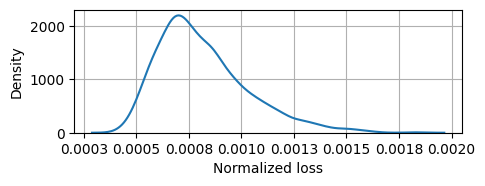

In [12]:
from matplotlib.ticker import FormatStrFormatter

sns.kdeplot(losses, bw_adjust=1)
plt.xlabel("Loss")
plt.ylabel("Density")
plt.grid()
plt.gcf().set_size_inches(5, 1.6)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter("%.4f"))
plt.savefig("../plots/analysis_distribution.svg")
plt.show()

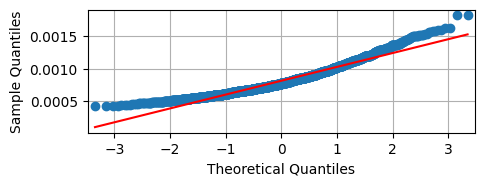

In [5]:
sm.qqplot(losses, line='s')
plt.grid()
plt.gcf().set_size_inches(5, 1.6)
plt.savefig("../plots/analysis_distribution_qq.svg")
plt.show()